## 1. Environment Setup

In [147]:
import os
import random
import yaml

### 1.1. Package Installs

In [ ]:
!pip install --quiet torchaudio librosa soundfile sentencepiece jiwer

### 1.2. Directories

In [149]:
# Load project paths from config.yaml
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Assign base directories
DATASET_DIR   = cfg["dataset_dir"]
SPLIT_DIR     = cfg["splits_dir"]
PREP_DIR      = cfg["preprocessed_dir"]
STATS_DIR     = cfg["stats_dir"]
TOKENIZER_DIR = cfg["tokenizer_dir"]

# Ensure dirs
for d in (DATASET_DIR, SPLIT_DIR, PREP_DIR, STATS_DIR, TOKENIZER_DIR):
    os.makedirs(d, exist_ok=True)

print(f"Loaded paths:\n"
      f" DATA_DIR      = {DATASET_DIR}\n"
      f" SPLIT_DIR     = {SPLIT_DIR}\n"
      f" PREP_DIR      = {PREP_DIR}\n"
      f" STATS_DIR     = {STATS_DIR}\n"
      f" TOKENIZER_DIR = {TOKENIZER_DIR}")

Loaded paths:
 DATA_DIR      = data/LJSpeech
 SPLIT_DIR     = data/splits
 PREP_DIR      = data/preprocessed
 STATS_DIR     = data/stats
 TOKENIZER_DIR = data/preprocessed/tokenizer


### 1.3. Random State

In [132]:
random.seed(21)

## 2. Load LJSpeech

In [126]:
import os
from torchaudio.datasets import LJSPEECH
from IPython.display import Audio

In [127]:
dataset = LJSPEECH(root=DATASET_DIR, download=False)
total   = len(dataset)
print(f"Loaded LJSpeech with {total} samples")

Loaded LJSpeech with 13100 samples


In [129]:
# Inspect sample #2
waveform, sr, transcript, norm_transcript = dataset[2]
print("Waveform shape:", waveform.shape)
print("Sample rate:   ", sr)
print("Raw text:      ", transcript)
print("Normalized:    ", norm_transcript)
Audio(waveform.numpy(), rate=sr)

Waveform shape: torch.Size([1, 213149])
Sample rate:    22050
Raw text:       For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
Normalized:     For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process


## 3. Audio → log-Mel spectrogram

In [100]:
import torch
import torchaudio.transforms as T

### 3.1. Define Transforms

In [101]:
n_fft     = 1024
hop_length= 256
n_mels    = 80

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)
amp_to_db = T.AmplitudeToDB(stype='power')

### 3.2. Wrapper Function

In [102]:
def make_log_mel(waveform: torch.Tensor) -> torch.Tensor:
    """Takes [1×N] waveform → [n_mels×T] log-Mel spectrogram."""
    spec = mel_spectrogram(waveform)       # → [1, n_mels, T]
    spec_db = amp_to_db(spec)              # → [1, n_mels, T]
    return spec_db.squeeze(0)              # → [n_mels, T]

# Test on first sample
log_mel = make_log_mel(waveform)
print("Log-Mel shape:", log_mel.shape)

Log-Mel shape: torch.Size([80, 833])


## 4. Text Normalizaton and Tokenizer

In [130]:
import random
import re
import unicodedata
from collections import Counter
import sentencepiece as spm

### 4.1. Text Normalization

#### 4.1.1 Normalization Audit

In [133]:
sample_size = min(1000, total)
sample_idxs = random.sample(range(total), k=sample_size)
transcripts  = [dataset[i][3] for i in sample_idxs]
full_text    = "\n".join(transcripts)

line_patterns = {
    "uppercase"        : re.compile(r"^[^\n]*[A-Z][^\n]*$", flags=re.MULTILINE),
    "curly_apostrophe" : re.compile(r"^[^\n]*[’‘][^\n]*$", flags=re.MULTILINE),
    "multi_hyphen"     : re.compile(r"^[^\n]*-{2,}[^\n]*$", flags=re.MULTILINE),
    "multi_space"      : re.compile(r"^[^\n]*\s{2,}[^\n]*$", flags=re.MULTILINE),
    "forbidden"        : re.compile(r"^[^\n]*[^a-z0-9!\'(),\-.:;? ][^\n]*$", flags=re.MULTILINE),
}
counts = {n: len(p.findall(full_text)) for n,p in line_patterns.items()}

print(f"\n Normalization audit on {sample_size} random samples:")
for name, cnt in counts.items():
    pct = cnt / sample_size * 100
    print(f"  • {name:14s}: {cnt:4d} samples ({pct:.1f}%)")

char_pattern = re.compile(r"[^a-z0-9!\'(),\-.:;? \n]")
forbidden_chars = char_pattern.findall(full_text)
if forbidden_chars:
    freq = Counter(forbidden_chars)
    print("\n Forbidden characters (total occurrences):")
    for ch, c in freq.most_common():
        print(f"    {repr(ch):>4s} → {c}")
else:
    print("\n No forbidden characters detected.")


 Normalization audit on 1000 random samples:
  • uppercase     :  819 samples (81.9%)
  • curly_apostrophe:    0 samples (0.0%)
  • multi_hyphen  :    3 samples (0.3%)
  • multi_space   :    0 samples (0.0%)
  • forbidden     :  500 samples (50.0%)

 Forbidden characters (total occurrences):
     'T' → 232
     'S' → 187
     'P' → 143
     'I' → 142
     'H' → 139
     'O' → 138
     'C' → 137
     'A' → 135
     'M' → 134
     'B' → 117
     '"' → 81
     'W' → 80
     'D' → 80
     'N' → 76
     'F' → 61
     'L' → 51
     'R' → 47
     'E' → 43
     'U' → 39
     'K' → 30
     'G' → 30
     'J' → 30
     'Y' → 14
     'V' → 13
     'Q' → 10
     'Z' → 2
     '[' → 1
     ']' → 1
     'ü' → 1


#### 4.1.2 Normalization Function

In [104]:
# Pre-compile nessecary regex patterns
_CURLY_APOSTROPHE = re.compile(r"[\u2018\u2019]")       # ‘ or ’
_MULTI_HYPHEN      = re.compile(r"-{2,}")               # -- or more
_MULTI_SPACE       = re.compile(r"\s{2,}")              # two or more spaces
_FORBIDDEN         = re.compile(r"[^a-z0-9!\'(),\-.:;? ]")  # outside allowed set

def normalize_text(text: str) -> str:
    """
    1. Decompose Unicode & strip diacritics (ü→u, é→e, etc.)
    2. Replace curly apostrophes with ASCII '
    3. Collapse multi-hyphens into single '-'
    4. Lowercase everything
    5. Remove forbidden characters (replace with space)
    6. Collapse multi-spaces and trim
    """
    text = unicodedata.normalize("NFD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")
    text = _CURLY_APOSTROPHE.sub("'", text)
    text = _MULTI_HYPHEN.sub("-", text)
    text = text.lower()
    text = _FORBIDDEN.sub(" ", text)
    text = _MULTI_SPACE.sub(" ", text).strip()
    return text

# Test on a few samples
for i in range(5):
  original_transcript = dataset[i][3]
  normalized_transcript = normalize_text(original_transcript)
  print(f"Sample {i+1}:")
  print("Original:", original_transcript)
  print("Normalized:", normalized_transcript)
  print("---")

Sample 1:
Original: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Normalized: printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition
---
Sample 2:
Original: in being comparatively modern.
Normalized: in being comparatively modern.
---
Sample 3:
Original: For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
Normalized: for although the chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the netherlands, by a similar process
---
Sample 4:
Original: produced the block books, which were the immediate predecessors of the true printed book,
Normalized: produced the block books, which were the immediate predecessors of the true printed book,
--

#### 4.1.3. Apply Normalization

In [134]:
clean_txt = os.path.join(PREP_DIR, "normalized_transcripts.txt")
with open(clean_txt, "w") as f:
    for *_, norm in dataset:
        f.write(normalize_text(norm) + "\n")
print(f"\n Saved cleaned transcripts → {clean_txt}")


 Saved cleaned transcripts → data/preprocessed/normalized_transcripts.txt


### 4.2. Tokenization

### 4.2.1. SentencePiece BPE Tokenizer

In [135]:
model_prefix = os.path.join(TOKENIZER_DIR, "ljspeech_bpe1000")
spm.SentencePieceTrainer.Train(
    input=clean_txt,
    model_prefix=model_prefix,
    vocab_size=1000,
    model_type="bpe",
    character_coverage=1.0,
    num_threads=os.cpu_count(),
)
print(f" Trained tokenizer → {model_prefix}.model & .vocab")

 Trained tokenizer → data/preprocessed/tokenizer/ljspeech_bpe1000.model & .vocab


In [136]:
# Load tokenizer
tokenizer = spm.SentencePieceProcessor(model_file=f"{model_prefix}.model")

## 5. Train / Val / Test Split

In [137]:
import json
import os

In [138]:
all_indices = list(range(total))
random.shuffle(all_indices)
t_end = int(0.8 * total)
v_end = t_end + int(0.1 * total)

splits = {
    "train": all_indices[:t_end],
    "val":   all_indices[t_end:v_end],
    "test":  all_indices[v_end:],
}

for name, idxs in splits.items():
    path = os.path.join(SPLIT_DIR, f"{name}_idx.json")
    with open(path, "w") as f:
        json.dump(idxs, f)
    print(f" Saved {name} split indices → {path}")

 Saved train split indices → data/splits/train_idx.json
 Saved val split indices → data/splits/val_idx.json
 Saved test split indices → data/splits/test_idx.json


## 6. Dataset Statistics

In [139]:
import random
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

### 6.1. Audio Duration Histogram

In [ ]:
durations = [wav.shape[1] / sr for wav, sr, *_, in dataset]

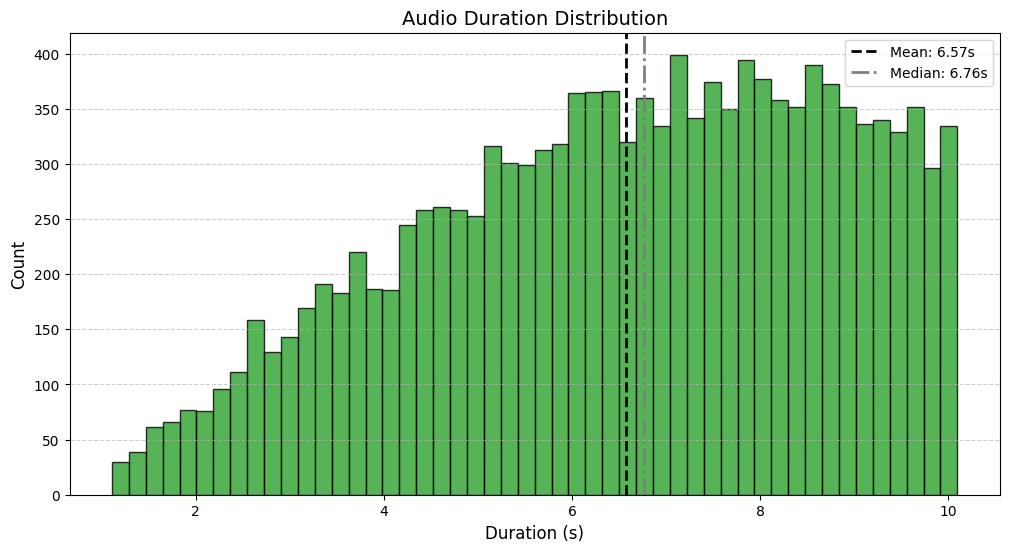

In [153]:
mean_dur = np.mean(durations)
median_dur = np.median(durations)

plt.figure(figsize=(12, 6))
plt.hist(durations, bins=50, color='#2ca02c', edgecolor='k', alpha=0.8)
plt.axvline(mean_dur, color='k', linestyle='--', linewidth=2, label=f'Mean: {mean_dur:.2f}s')
plt.axvline(median_dur, color='gray', linestyle='-.', linewidth=2, label=f'Median: {median_dur:.2f}s')
plt.title('Audio Duration Distribution', fontsize=14)
plt.xlabel('Duration (s)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
hist_path = os.path.join(STATS_DIR, 'duration_hist.png')
plt.savefig(hist_path, dpi=300, bbox_inches='tight')
plt.show()

### 6.2. Spectrogram Length vs. Token Length Scatter

In [142]:
spec_lens, token_lens = [], []
for i in random.sample(range(total), 1000):
    wav, _, _, raw_norm = dataset[i]
    spec = make_log_mel(wav)
    spec_lens.append(spec.shape[1])
    token_lens.append(len(tokenizer.encode(normalize_text(raw_norm))))

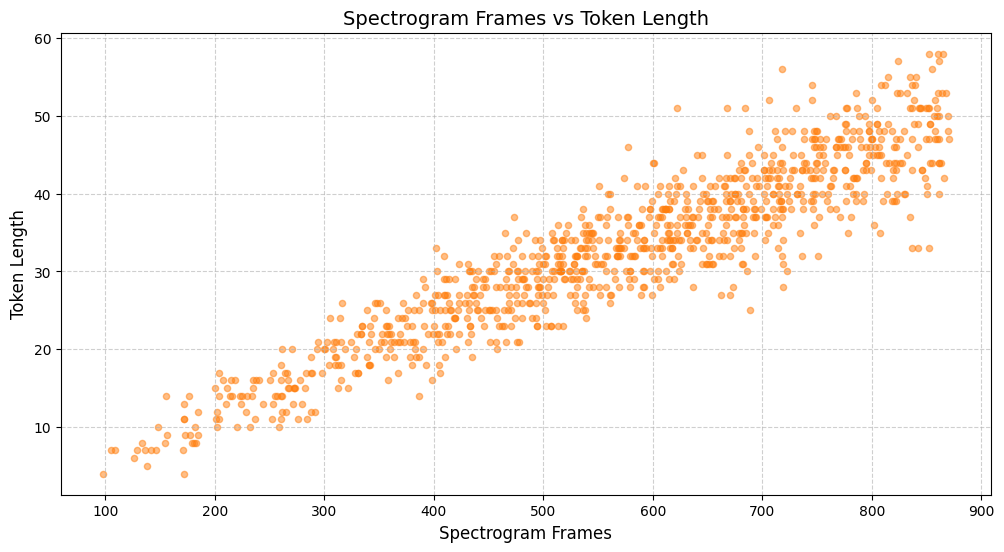

In [154]:
plt.figure(figsize=(12, 6))
plt.scatter(spec_lens, token_lens, alpha=0.5, s=20, color='#ff7f0e')
plt.title('Spectrogram Frames vs Token Length', fontsize=14)
plt.xlabel('Spectrogram Frames', fontsize=12)
plt.ylabel('Token Length', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
scatter_path = os.path.join(STATS_DIR, 'spec_token_scatter.png')
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
plt.show()

## 6.3. Example: Waveform + Spectrogram + Tokens

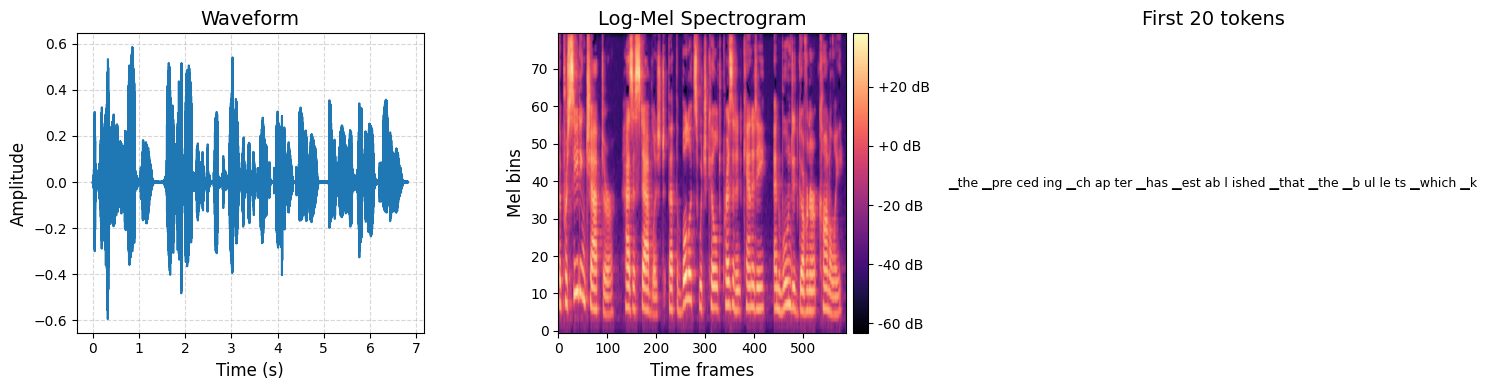

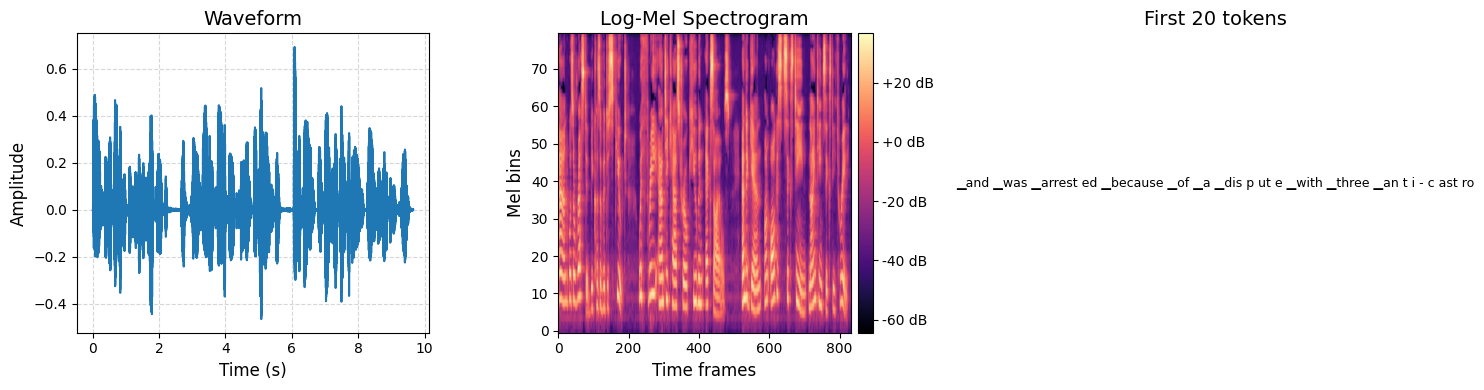

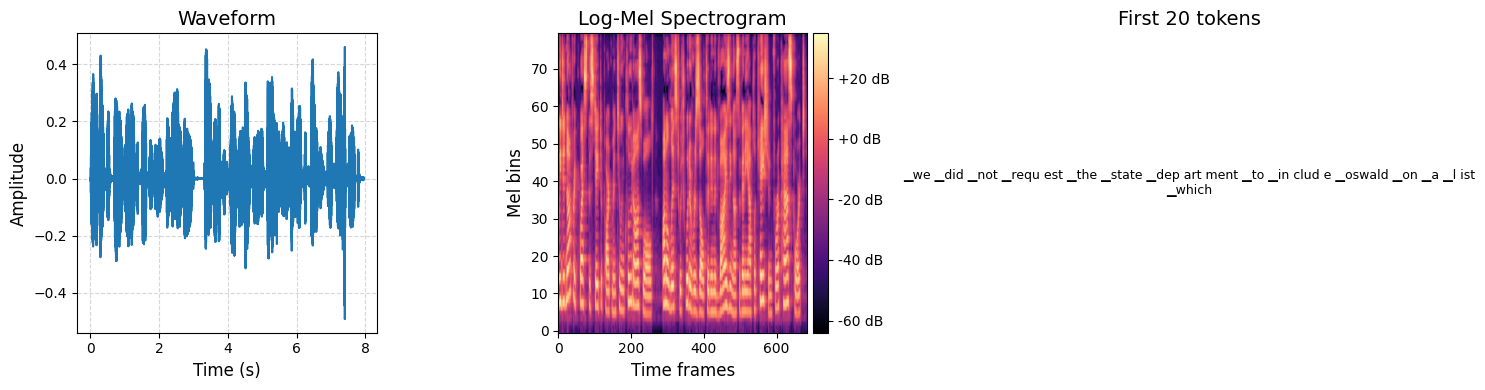

In [155]:
examples_dir = os.path.join(STATS_DIR, "examples")
os.makedirs(examples_dir, exist_ok=True)

for idx in random.sample(range(total), 3):
    wav, sr, _, raw_norm = dataset[idx]
    norm = normalize_text(raw_norm)
    ids  = tokenizer.encode(norm)
    spec = make_log_mel(wav)

    # Time axis for waveform
    times = np.arange(wav.shape[1]) / sr

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1) Waveform
    axes[0].plot(times, wav.squeeze().numpy(), color='#1f77b4')
    axes[0].set_title("Waveform", fontsize=14)
    axes[0].set_xlabel("Time (s)", fontsize=12)
    axes[0].set_ylabel("Amplitude", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # 2) Log-Mel Spectrogram
    img = axes[1].imshow(
        spec.numpy(),
        aspect='auto',
        origin='lower',
        cmap='magma'
    )
    axes[1].set_title("Log-Mel Spectrogram", fontsize=14)
    axes[1].set_xlabel("Time frames", fontsize=12)
    axes[1].set_ylabel("Mel bins", fontsize=12)
    plt.colorbar(img, ax=axes[1], format='%+2.0f dB', pad=0.02)

    # 3) Token preview
    token_pieces = tokenizer.id_to_piece(ids[:20])
    axes[2].text(
        0.5, 0.5,
        " ".join(token_pieces),
        wrap=True, ha='center', va='center', fontsize=9
    )
    axes[2].set_title("First 20 tokens", fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()

    # Save and display
    example_path = os.path.join(examples_dir, f"example_{idx}.png")
    fig.savefig(example_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)